# PlayerData Data Scientist Internship Technical Task

In [1]:
import numpy as np
import pandas as pd

import pywt

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import networkx as nx

In [2]:
# Lets open our background pitch image.
Image.MAX_IMAGE_PIXELS = None
pitch_image = Image.open("image.jpeg")

In [3]:
match_data = pd.read_csv("datasets/match_data.csv")
sorted_match_data = match_data[match_data["participation_id"] != 'ball'].sort_values(by=['participation_id', 'Time (s)'])

# Task 1

## Removing noise

In [4]:
def wavelet_smoothing(data, wavelet_name='db4'):
    coeffs = pywt.wavedec(data, wavelet_name, mode='per')
    sigma = np.std(coeffs[-1])
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    coeffs = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeffs]
    smoothed_data = pywt.waverec(coeffs, wavelet_name, mode='per')
    
    # Handle potential length issues
    if len(smoothed_data) > len(data):
        smoothed_data = smoothed_data[:len(data)]  # Trim if longer
    elif len(smoothed_data) < len(data):
        # Pad if shorter
        smoothed_data = np.pad(smoothed_data, (0, len(data) - len(smoothed_data)), 'edge')
    
    return smoothed_data

In [5]:
sorted_match_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 920042 entries, 636 to 985273
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   participation_id  920042 non-null  object 
 1   Time (s)          920042 non-null  float64
 2   Pitch_x           920042 non-null  float64
 3   Pitch_y           920042 non-null  float64
 4   Speed (m/s)       920042 non-null  float64
dtypes: float64(4), object(1)
memory usage: 42.1+ MB


In [6]:
smoothed_df = sorted_match_data.copy()

for column in ['Speed (m/s)', 'Pitch_x', 'Pitch_y']:
    smoothed_df[column] = sorted_match_data.groupby('participation_id')[column].transform(wavelet_smoothing)


In [7]:
smoothed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 920042 entries, 636 to 985273
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   participation_id  920042 non-null  object 
 1   Time (s)          920042 non-null  float64
 2   Pitch_x           920042 non-null  float64
 3   Pitch_y           920042 non-null  float64
 4   Speed (m/s)       920042 non-null  float64
dtypes: float64(4), object(1)
memory usage: 42.1+ MB


### Removing Data Outside of Human Movement Limits

Usain bolt has achieved an accelleration of aroung 9.5m/s^2 at his top, so lets take this as our maximum threshole. [https://www.science.org/content/article/scienceshot-physics-usain-bolt] While footballers often have better instantanious accelleration then sprinters, sprinters peak accelleration periods are generally better. 

Therefore, it is reasonable to assume that there should be no changes in speed greater than 0.95m/s while a player is accelerating. 
While it is possible that due to collisions instantanious decelleration could occur at such a rate, these would be outliers that for the purpose of this investigation would be okay to discard.

In [8]:
smoothed_df['time_diff_next'] = smoothed_df.groupby('participation_id')['Time (s)'].diff(-1).abs()
smoothed_df['time_diff_prev'] = smoothed_df.groupby('participation_id')['Time (s)'].diff(1).abs()

# Calculate the speed differences with previous and next points
smoothed_df['speed_diff_prev'] = abs(smoothed_df['Speed (m/s)'] - smoothed_df.groupby('participation_id')['Speed (m/s)'].shift(1))
smoothed_df['speed_diff_next'] = abs(smoothed_df.groupby('participation_id')['Speed (m/s)'].shift(-1) - smoothed_df['Speed (m/s)'])

# Base threshold for speed differences
base_threshold = 0.95

# Dynamically adjust the threshold based on the time differences
smoothed_df['dynamic_threshold_speed_prev'] = base_threshold * (10 * smoothed_df['time_diff_prev'])
smoothed_df['dynamic_threshold_speed_next'] = base_threshold * (10 * smoothed_df['time_diff_next'])

# Identify points where the speed difference to both adjacent points exceeds the dynamically adjusted threshold
smoothed_df['speed_change_exceeds_dynamic_threshold'] = ((smoothed_df['speed_diff_prev'] > smoothed_df['dynamic_threshold_speed_prev']) |
                                                                (smoothed_df['speed_diff_next'] > smoothed_df['dynamic_threshold_speed_next']))

The top recorded speed achieved by a professional footballer is Micky van de Ven at 10.38 m/s [https://www.premierleague.com/news/3884168].

Therefore, no point should be more than 1.038m away from any given other consecutive data point on the pitch.

We can therefore use this as a maximum threshold for removing noise related to positional data.

In [9]:
# Calculate changes for x and y to previous and next points
smoothed_df['delta_x_prev'] = smoothed_df['Pitch_x'] - smoothed_df.groupby('participation_id')['Pitch_x'].shift(1)
smoothed_df['delta_y_prev'] = smoothed_df['Pitch_y'] - smoothed_df.groupby('participation_id')['Pitch_y'].shift(1)
smoothed_df['delta_x_next'] = smoothed_df.groupby('participation_id')['Pitch_x'].shift(-1) - smoothed_df['Pitch_x']
smoothed_df['delta_y_next'] = smoothed_df.groupby('participation_id')['Pitch_y'].shift(-1) - smoothed_df['Pitch_y']

# Calculate the Euclidean distances to previous and next points
smoothed_df['distance_to_prev'] = np.sqrt(smoothed_df['delta_x_prev']**2 + smoothed_df['delta_y_prev']**2)
smoothed_df['distance_to_next'] = np.sqrt(smoothed_df['delta_x_next']**2 + smoothed_df['delta_y_next']**2)

# Base threshold
base_threshold = 1.038

# Calculate dynamic thresholds based on time differences
# Assume 'time_diff_prev' and 'time_diff_next' are already calculated as shown in your previous steps
smoothed_df['dynamic_threshold_prev'] = base_threshold * (10 * smoothed_df['time_diff_prev'])
smoothed_df['dynamic_threshold_next'] = base_threshold * (10 * smoothed_df['time_diff_next'])

# Identify points more than dynamically calculated distance away from both neighbors
smoothed_df['more_than_dynamic_dist_away'] = ((smoothed_df['distance_to_prev'] > smoothed_df['dynamic_threshold_prev']) |
                                               (smoothed_df['distance_to_next'] > smoothed_df['dynamic_threshold_next']))


In [10]:
human_limits_only_df = smoothed_df[(smoothed_df['more_than_dynamic_dist_away'] == False) &
                                   (smoothed_df['speed_change_exceeds_dynamic_threshold'] == False)]

In [11]:
def tokmph(mps : np.float64) -> np.float64:
    metres_ph = mps * 3600
    kmph = metres_ph / 1000
    return kmph

human_limits_only_df["Speed (km/h)"] = human_limits_only_df["Speed (m/s)"].apply(tokmph)
human_limits_only_df.drop(columns="Speed (m/s)", inplace=True)

/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_3804/1448145780.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_limits_only_df["Speed (km/h)"] = human_limits_only_df["Speed (m/s)"].apply(tokmph)
/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_3804/1448145780.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_limits_only_df.drop(columns="Speed (m/s)", inplace=True)


### Removing Data Outiside of Pitch Boundaries

In [12]:
inside_pitch = human_limits_only_df[(human_limits_only_df["Pitch_x"] > -52.5) & (human_limits_only_df["Pitch_x"] < 52.5) &
                                 (human_limits_only_df["Pitch_y"] > -34.0) & (human_limits_only_df["Pitch_y"] < 34.0)]

### Splitting the pitch into zones

Lets divide up the pitch into 9 zones.

Lengthways, we will split it into equal thirds, with the defensive, middle and attacking thirds of the pitch. Here we will assume that attacking is positive on the x values and defensive is negative.

We will again be dividing the pitch into three zones vertically. These being - the centre of the pitch (consisting of the centre space and half spaces) as well as the wide areas.

Therefore, the defensive third will be from -52.5 to -17.500001 x, the middle third from -17.5 to 17.5 x, and the attacking third from 17.500001 to 52.5 x.

The central area vertically will be 40.23m (44 yrds, the width of the pentalty area) wide with the left and right wide areas split into the remaiders of the pitch (13.885m wide each).

Therefore, the right wide area will be from -34 to -20.115001, the central area from -20.115 to 20.115, and the left wide area from 20.115001 to 34.

Zone 1 will be the defensive left corner, zone 2 the central defensive area, all the way up to zone 9, the attacking right corner.

In [13]:
def determine_zone(row):
    if -52.5 <= row['Pitch_x'] < -17.5 and -34 <= row['Pitch_y'] < -20.115:
        return 3
    elif -52.5 <= row['Pitch_x'] < -17.5 and -20.115 <= row['Pitch_y'] <= 20.115:
        return 2
    elif -52.5 <= row['Pitch_x'] < -17.5 and 20.115 < row['Pitch_y'] <= 34:
        return 1
    
    elif -17.5 <= row['Pitch_x'] <= 17.5 and -34 <= row['Pitch_y'] < -20.115:
        return 6
    elif -17.5 <= row['Pitch_x'] <= 17.5 and -20.115 <= row['Pitch_y'] <= 20.115:
        return 5
    elif -17.5 <= row['Pitch_x'] <= 17.5 and 20.115 < row['Pitch_y'] <= 34:
        return 4
    
    elif 17.5 < row['Pitch_x'] <= 52.5 and -34 <= row['Pitch_y'] < -20.115:
        return 9
    elif 17.5 < row['Pitch_x'] <= 52.5 and -20.115 <= row['Pitch_y'] <= 20.115:
        return 8
    elif 17.5 < row['Pitch_x'] <= 52.5 and 20.115 < row['Pitch_y'] <= 34:
        return 7
    
inside_pitch["Zone"] = inside_pitch.apply(determine_zone, axis=1)

/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_3804/3519411519.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inside_pitch["Zone"] = inside_pitch.apply(determine_zone, axis=1)


In [14]:
# Here we cut out all the data at half time, 
# we then also mulitply the coordinated for pitch x and y by -1 in the second half to keep it consistent with the first
inside_pitch = inside_pitch[(inside_pitch['Time (s)'] < 2850) | (inside_pitch['Time (s)'] > 3650)]
inside_pitch.loc[inside_pitch['Time (s)'] > 3650, ['Pitch_x', 'Pitch_y']] *= -1

# Task 2

### Classifying high intensity periods

In [15]:
inside_pitch["High intensity"] = inside_pitch["Speed (km/h)"].between(19.8, 25.1)

In [16]:
#Lets then classify any points in which we move into or out of a high intensity speed (not yet looking at events as a whole)
#Also accounts for the possibility of data stopping for a participant while still at a high intensity.

# Intensity increase from previous
inside_pitch["Intensity increase from previous"] = (
    (inside_pitch["High intensity"]) & 
    ((inside_pitch["High intensity"].shift(1) == False) | (inside_pitch["participation_id"] != inside_pitch["participation_id"].shift(1))))

# Intensity decrease to next
inside_pitch["Intensity decrease to next"] = (
    (inside_pitch["High intensity"]) & 
    ((inside_pitch["High intensity"].shift(-1) == False) | (inside_pitch["participation_id"] != inside_pitch["participation_id"].shift(-1))))

high_intensity_data = inside_pitch[inside_pitch["High intensity"]].copy()

In [17]:
#Assign each high intensity period an ID. Simply a number that increases by 1 for the start of eacn period.
high_intensity_data["Period id"] = inside_pitch["Intensity increase from previous"].cumsum()

#For each high intensity period collect the start and end times, as well as all the zones it goes through.
high_intensity_periods = high_intensity_data.groupby(['participation_id', 'Period id']).agg(
    Time_start = ('Time (s)', 'min'),
    Time_end = ('Time (s)', 'max'),
    Zones = ('Zone', lambda x: list(set(x)))  # Collect unique zones as a list
).reset_index()

#Filter out all under 0.5s
high_intensity_periods['Duration'] = high_intensity_periods['Time_end'] - high_intensity_periods['Time_start']
high_intensity_periods = high_intensity_periods[high_intensity_periods['Duration'] > 0.5]

#Explode where one passes through multiple zones.
high_intensity_periods_exploded = high_intensity_periods.copy().explode('Zones')

high_intensity_event_counts = high_intensity_periods_exploded.groupby(['participation_id', 'Zones']).size().reset_index(name='High Intensity Event Count')

### Putting them into a readable format

In [18]:
#Okay to iterate here as dealing with a fixed size of 9 * participants. 
#Participants should never be too large (in this case <= 17)

#Here we add 0 counts for each participant/zone with no information 
rows_list = []

for participant in sorted_match_data['participation_id'].unique():
    for zone in range(1, 10):
        # Try to get the count for the current participant and zone
        count_series = high_intensity_event_counts.loc[
            (high_intensity_event_counts["participation_id"] == participant) &
            (high_intensity_event_counts["Zones"] == zone),
            "High Intensity Event Count"
        ]
        
        #Get the number of high intensity events per zone per participant.
        #If it's an empty series we default to 0
        count = count_series.iloc[0] if not count_series.empty else 0
        
        # Create a dictionary for the zone/participant
        row_dict = {
            "participation_id": participant,
            "Zone": zone,
            "High Intensity Event Count": count
        }
        
        # Append the dictionary to the list
        rows_list.append(row_dict)

# Create a DataFrame from the list of dictionaries
high_intensity_event_counts_complete = pd.DataFrame(rows_list)

In [19]:
high_intensity_event_counts_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   participation_id            144 non-null    object
 1   Zone                        144 non-null    int64 
 2   High Intensity Event Count  144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


In [20]:
high_intensity_event_counts_complete.to_csv('datasets/high_intensity_events.csv', index=False)

### Visualisation

This has been included seperately as due to the image overlay it can take several minutes to run.

Please see "high_intensity_events_areas.pdf" in the task_visualisation folder, or run the python file high_intensity_events_visualisation.py.

# Task 3 - Passes and Average positions

Here we will be inspecting the passes made between different players, as well as where they are taking up their positions. 

This would be useful as it would allow managers to analyse the roles and importance of different players in posession.
They could see which combinations of players are playing well together or where the roles of different players are clashing. It would also allow them to analyse which players are most important to the team's build up, and whether certain players are struggling to get on the ball, whether that be due to their own instructions, the opposition, or the players themselves. 

In [21]:
#Extract only the original columns
cleaned_data = inside_pitch[['participation_id', 'Time (s)', 'Pitch_x', 'Pitch_y', 'Speed (km/h)']].copy()

In [22]:
#Extract the data from the ball.
#Data for the ball cuts off after 27 minutes, so we will only be analysing up to this point.
ball_data = match_data[(match_data["participation_id"] == 'ball') & (match_data["Time (s)"] < 1730 ) ] 

#Smooth the ball data using wavelet smoothing.
for column in ['Speed (m/s)', 'Pitch_x', 'Pitch_y']:
    ball_data[column] = ball_data.groupby('participation_id')[column].transform(wavelet_smoothing)

ball_data["Speed (km/h)"] = ball_data["Speed (m/s)"].apply(tokmph)
ball_data.drop(columns="Speed (m/s)", inplace=True)

ball_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16563 entries, 7274 to 269425
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   participation_id  16563 non-null  object 
 1   Time (s)          16563 non-null  float64
 2   Pitch_x           16563 non-null  float64
 3   Pitch_y           16563 non-null  float64
 4   Speed (km/h)      16563 non-null  float64
dtypes: float64(4), object(1)
memory usage: 776.4+ KB


/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_3804/1665462203.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ball_data[column] = ball_data.groupby('participation_id')[column].transform(wavelet_smoothing)
/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_3804/1665462203.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ball_data[column] = ball_data.groupby('participation_id')[column].transform(wavelet_smoothing)
/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_3804/1665

### Defining posession

In [23]:
time_indexed_ball = ball_data.set_index('Time (s)')

# def get_closest_to_ball(timestep):
#     ball_loc = (time_indexed_ball.at[timestep, 'Pitch_x'], time_indexed_ball.at[timestep, 'Pitch_y'])
#     player_locs = cleaned_data[cleaned_data['Time (s)'] == timestep]

#     if player_locs.empty:
#         return pd.NA, pd.NA
#     else:
#         player_locs['Distance_to_ball'] = np.sqrt((player_locs["Pitch_x"] - ball_loc[0])**2 + 
#                                                   (player_locs["Pitch_y"] - ball_loc[1])**2 )
#         closest_distance = player_locs['Distance_to_ball'].min()
#         closest_player = player_locs[player_locs['Distance_to_ball'] == closest_distance].iloc[0]['participation_id']

#         return closest_player, closest_distance


def get_distances(ball_time):
    try:
        ball_row = time_indexed_ball.loc[ball_time]
        ball_pos = np.array([ball_row['Pitch_x'], ball_row['Pitch_y']])
        
        player_rows = cleaned_data[cleaned_data['Time (s)'] == ball_time]
        player_positions = player_rows[['Pitch_x', 'Pitch_y']].to_numpy()
        
        distances = np.sqrt(((player_positions - ball_pos) ** 2).sum(axis=1))
        min_index = np.argmin(distances)
        closest_player = player_rows.iloc[min_index]['participation_id']
        closest_distance = distances[min_index]
        
        return closest_player, closest_distance
    except Exception as e:
        print(e)
        return pd.NA, pd.NA
    
results = time_indexed_ball.index.map(get_distances)
ball_data['Closest_player'], ball_data['Closest_distance'] = zip(*results)
ball_data['In_possession'] = ball_data['Closest_distance'] <= 2

ball_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16563 entries, 7274 to 269425
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   participation_id  16563 non-null  object 
 1   Time (s)          16563 non-null  float64
 2   Pitch_x           16563 non-null  float64
 3   Pitch_y           16563 non-null  float64
 4   Speed (km/h)      16563 non-null  float64
 5   Closest_player    16563 non-null  object 
 6   Closest_distance  16563 non-null  float64
 7   In_possession     16563 non-null  bool   
dtypes: bool(1), float64(5), object(2)
memory usage: 1.0+ MB


/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_3804/2306287561.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ball_data['Closest_player'], ball_data['Closest_distance'] = zip(*results)
/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_3804/2306287561.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ball_data['Closest_player'], ball_data['Closest_distance'] = zip(*results)
/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_3804/2306287561.py:38: SettingWithCopyWarning: 

In [24]:
ball_data[ball_data['In_possession']].shape

(799, 8)

### Classifying passes

Here we determine where passes have been played.

A pass is played if the ball shifts from being in the possession of one player to another without any significant or sudden change in direction over the course of the movement (which would suggest that the ball has been intercepted). We check changes in direction over 0.3s intervals rather than 0.1 due to the fact that there is unlikely to be more than a slight change regardless over such smaller intervals.

In [25]:
# Calculate position of ball 0.3 seconds later than current.
time_shift = 0.3
ball_data['Future_Pitch_x'] = ball_data['Pitch_x'].shift(-int(time_shift / 0.1))
ball_data['Future_Pitch_y'] = ball_data['Pitch_y'].shift(-int(time_shift / 0.1))

# Calculate direction of travel between t and t+0.3s
ball_data['dx'] = ball_data['Future_Pitch_x'] - ball_data['Pitch_x']
ball_data['dy'] = ball_data['Future_Pitch_y'] - ball_data['Pitch_y']
ball_data['direction'] = np.arctan2(ball_data['dy'], ball_data['dx'])

# Detect where possession changes out of one team or another. This is identifying long passes where the ball goes out
# possession before coming back into possession when received.
ball_data['possession_change'] = ball_data['In_possession'].diff().fillna(0) != 0
possession_changes = ball_data[ball_data['possession_change']].index

# Detect where a short pass is played (<=4m). This is where the closest player changes but posession stays true.
ball_data['Previous_Closest_Player'] = ball_data['Closest_player'].shift(1).fillna(method='bfill')  # Previous player
ball_data['Next_Closest_Player'] = ball_data['Closest_player'].shift(-1).fillna(method='ffill')  # Next player
ball_data['Short_passes'] = (
    (ball_data['In_possession'] == True) &
    ((ball_data['Closest_player'] != ball_data['Previous_Closest_Player']) |
     (ball_data['Closest_player'] != ball_data['Next_Closest_Player']))
)
short_passes = ball_data[ball_data['Short_passes']].index


# Drop rows where future positions are NaN (will be the last 0.3s)
ball_data.dropna(subset=['Future_Pitch_x', 'Future_Pitch_y'], inplace=True)

#Checks whether there is a significant change in the direction of travel of the ball.
def check_pass(slice_df):
    directions = slice_df['direction']
    if len(directions) < 2:
        return False
    direction_changes = np.abs(np.diff(directions))
    return np.all(direction_changes < np.deg2rad(30))

# Get the positions of the possession changes in the DataFrame
possession_changes_positions = [ball_data.index.get_loc(time) for time in possession_changes]
short_passes_positions = [ball_data.index.get_loc(time) for time in short_passes]

# Identify passes based on consistent direction between possessions
passes = []
for start_pos, end_pos in zip(possession_changes_positions[:-1], possession_changes_positions[1:]):
    # Check that th pass is valid: no significant changes in dir and the posession goes from one to another.
    if check_pass(ball_data.iloc[start_pos+1:end_pos]) and ball_data.iloc[start_pos]['Closest_player'] != ball_data.iloc[end_pos]['Closest_player']:
        passes.append([ball_data.iloc[start_pos]['Time (s)'], ball_data.iloc[end_pos]['Time (s)'], ball_data.iloc[start_pos]['Closest_player'], ball_data.iloc[end_pos]['Closest_player']])

for start_pos, end_pos in zip(short_passes_positions[:-1], short_passes_positions[1:]):
    # Check that any short passes are valid, same as before.
    if check_pass(ball_data.iloc[start_pos+1:end_pos]) and ball_data.iloc[start_pos]['Closest_player'] != ball_data.iloc[end_pos]['Closest_player']:
        passes.append([ball_data.iloc[start_pos]['Time (s)'], ball_data.iloc[end_pos]['Time (s)'], ball_data.iloc[start_pos]['Closest_player'], ball_data.iloc[end_pos]['Closest_player']])

print("Identified Passes:", passes)


Identified Passes: [[75.5, 76.5, '320d9832-0fdf-400e-b4e1-0d2b56144cf9', 'a04c9fce-b4f1-4f7f-82be-ed9e8f21feb8'], [258.5, 259.5, '320d9832-0fdf-400e-b4e1-0d2b56144cf9', 'd56ca4de-1be4-499a-8242-b219e051f33c'], [296.9, 298.4, 'b4498a98-9d30-4f18-8cdf-884774505d34', '3b7ea68d-8174-4061-94cc-84a07d488cfe'], [315.2, 319.1, 'd56ca4de-1be4-499a-8242-b219e051f33c', 'a7cc7c2e-350d-47a3-9d76-e40bc7cffa9e'], [343.5, 344.8, 'd56ca4de-1be4-499a-8242-b219e051f33c', '019d8fa9-3cbd-42f2-bfcf-1bc676d13e0f'], [454.3, 455.2, 'b4498a98-9d30-4f18-8cdf-884774505d34', 'd56ca4de-1be4-499a-8242-b219e051f33c'], [468.8, 469.4, 'a7cc7c2e-350d-47a3-9d76-e40bc7cffa9e', '3b7ea68d-8174-4061-94cc-84a07d488cfe'], [562.7, 564.4, 'b4498a98-9d30-4f18-8cdf-884774505d34', 'a04c9fce-b4f1-4f7f-82be-ed9e8f21feb8'], [595.4, 598.4, '0c7c551a-93df-416d-a892-81eccd50c6eb', 'a7cc7c2e-350d-47a3-9d76-e40bc7cffa9e'], [609.0, 609.7, '5f9839df-d91a-4ecd-b446-795329b174a5', '320d9832-0fdf-400e-b4e1-0d2b56144cf9'], [610.3, 617.1, '5f9839

/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_3804/686863024.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ball_data['Future_Pitch_x'] = ball_data['Pitch_x'].shift(-int(time_shift / 0.1))
/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_3804/686863024.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ball_data['Future_Pitch_y'] = ball_data['Pitch_y'].shift(-int(time_shift / 0.1))
/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_3804/686863024.py:7: SettingWithCopyWar

### Visualisations

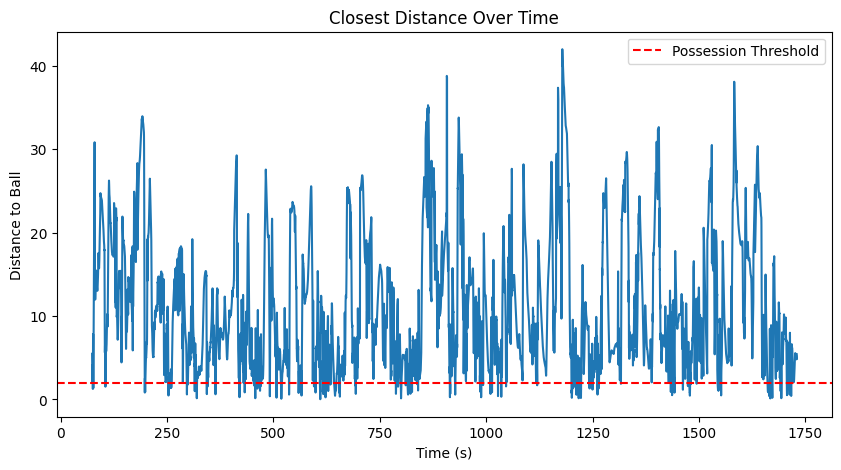

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(ball_data['Time (s)'], ball_data['Closest_distance'])
plt.title('Closest Distance Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Distance to Ball')
plt.axhline(y=2, color='r', linestyle='--', label='Possession Threshold')
plt.legend()
plt.show()

Above we can see that the team clearly does not have much possession of the ball, including spending periods sat far away from it.

In [27]:
ball_data['Closest_distance'].describe()

count    16561.000000
mean        11.303925
std          8.027156
min          0.027469
25%          4.973812
50%          9.025818
75%         16.275156
max         41.987504
Name: Closest_distance, dtype: float64

Let's create a graph with all of the passes between players. We will treat players as nodes and passes as edges.

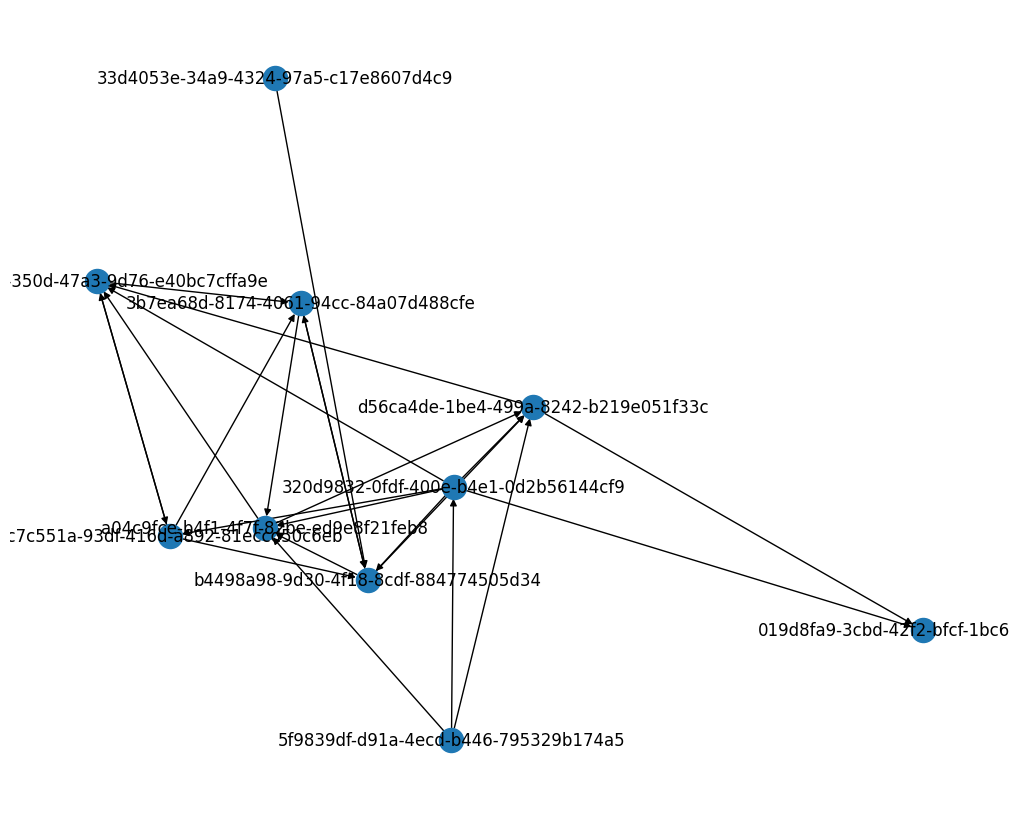

In [28]:
G = nx.DiGraph()

for p in passes:
    G.add_edge(p[2], p[3])

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True)
plt.show()

Interesting that there is only data for 10 players here. I have also manually verified this looking at the data, and barring the odd spike (likely noise), only ten of the players are present within the pitch within this time period.

Let's also size nodes according to how many passes players received and sent. We will also place players in their average positions over the course of the 30 minutes and size edges according to how many passes were played between players.

In [29]:
# Calculate average positions
avg_positions = cleaned_data[cleaned_data['Time (s)'] < 1730].groupby('participation_id')[['Pitch_x', 'Pitch_y']].mean()
position_dict = {index: (row['Pitch_x'], row['Pitch_y']) for index, row in avg_positions.iterrows()}


pass_counts = pd.DataFrame(passes, columns=['start_time', 'end_time', 'passer', 'receiver'])
pass_counts['count'] = 1

# Count how many times each player passed and received the ball
pass_made_counts = pass_counts['passer'].value_counts()
pass_received_counts = pass_counts['receiver'].value_counts()
total_pass_counts = pass_made_counts.add(pass_received_counts, fill_value=0)

# Normalize size for visualization
min_size = 100
max_size = 1000
min_passes = min(total_pass_counts)
max_passes = max(total_pass_counts)
node_size_normalized = {k: ((v - min_passes) / (max_passes - min_passes) * (max_size - min_size) + min_size) for k, v in total_pass_counts.items()}

# Create the graph
G = nx.Graph()
for p in passes:
    # Weight is number of passes per player
    if G.has_edge(p[2], p[3]):
        G[p[2]][p[3]]['weight'] += 1
    else:
        G.add_edge(p[2], p[3], weight=1)

# Normalize edge widths based on weight
weights = nx.get_edge_attributes(G, 'weight')
max_weight = max(weights.values())
min_width = 0.5
max_width = 5.0 
widths = [min_width + (max_width - min_width) * (weight / max_weight) for weight in weights.values()]

filtered_position_dict = {node: position for node, position in position_dict.items() if node in G.nodes()}

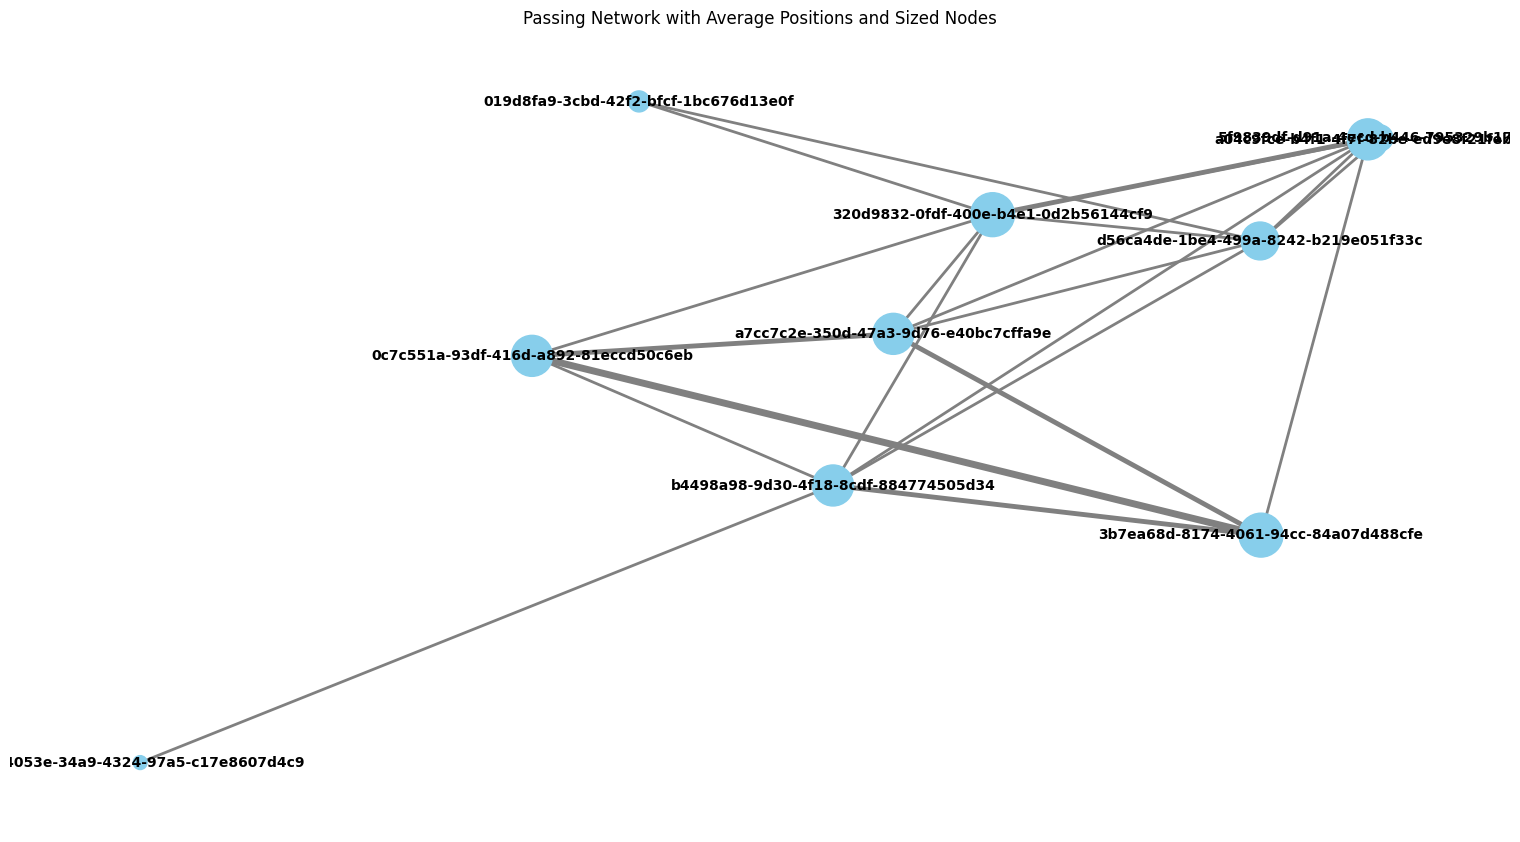

In [30]:
plt.figure(figsize=(15, 8))
nx.draw(G, 
        pos=filtered_position_dict,
        with_labels=True, 
        node_size=[node_size_normalized[node] for node in G.nodes()],
        width=widths,
        node_color='skyblue', 
        edge_color='gray', 
        font_size=10, 
        font_weight='bold')
plt.title('Passing Network with Average Positions and Sized Nodes')
plt.show()


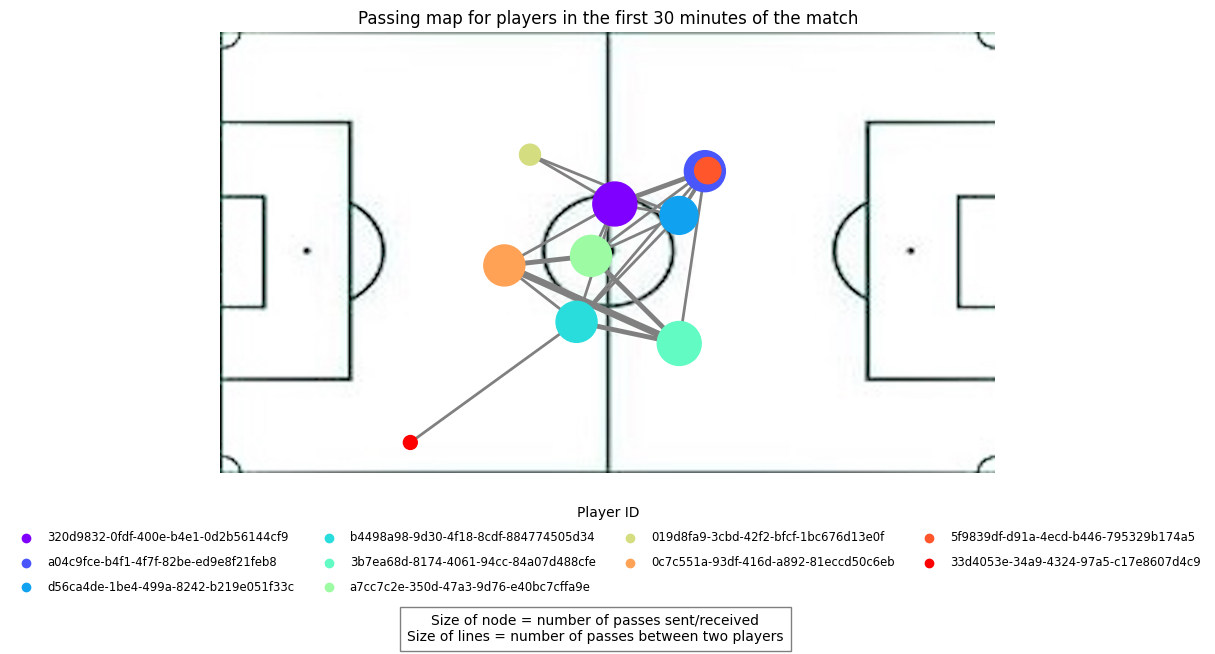

In [31]:
fig, ax = plt.subplots(figsize=(10, 7))

plt.title("Passing map for players in the first 30 minutes of the match")

# Define the extent of the pitch image to match the pitch dimensions
extent = [-52.5, 52.5, -34, 34]

# Pitch as background of the plot
ax.imshow(pitch_image, extent=extent, aspect='auto')

# Generate a unique color for each node
colors = plt.cm.rainbow(np.linspace(0, 1, len(G.nodes())))
node_color_map = dict(zip(G.nodes(), colors))

nx.draw(G, 
        pos=filtered_position_dict, 
        with_labels=False, 
        node_size=[node_size_normalized[node] for node in G.nodes()],
        width=widths,
        node_color=[node_color_map[n] for n in G.nodes()], 
        edge_color='gray', 
        font_size=10, 
        font_weight='bold', 
        ax=ax)


# Create legend
for node_id, color in node_color_map.items():
    plt.scatter([], [], color=color, label=node_id)
plt.subplots_adjust(bottom=0.25)
leg = plt.legend(scatterpoints=1, frameon=False, labelspacing=1, 
                 title='Player ID', loc='upper center', bbox_to_anchor=(0.5, -0.05),
                 fancybox=True, shadow=True, ncol=4, fontsize='small')

note = ("Size of node = number of passes sent/received\n"
        "Size of lines = number of passes between two players")
plt.figtext(0.5, 0.01, note, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})


# Set the same limits as the extent to ensure the network matches the pitch
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

# Remove axes and display
ax.axis('off')
plt.savefig("task_visualisation/pass_map.pdf")
plt.show()

Hmm, just out of interests, I want to see some heatmaps for the two player's who's average positions are very similar. This should help us identify how similar their movements actually are.

In [32]:
for key in filtered_position_dict:
    print(key, filtered_position_dict.get(key))

019d8fa9-3cbd-42f2-bfcf-1bc676d13e0f (-10.541567304566279, 15.08474828011606)
0c7c551a-93df-416d-a892-81eccd50c6eb (-14.020137021346498, -1.9933316330108029)
320d9832-0fdf-400e-b4e1-0d2b56144cf9 (0.9492212841822517, 7.482207506739673)
33d4053e-34a9-4324-97a5-c17e8607d4c9 (-26.756616836353786, -29.295030449917505)
3b7ea68d-8174-4061-94cc-84a07d488cfe (9.67600781143938, -14.027193381996932)
5f9839df-d91a-4ecd-b446-795329b174a5 (13.538568197624524, 12.630544222937214)
a04c9fce-b4f1-4f7f-82be-ed9e8f21feb8 (13.149905046768707, 12.537832249675908)
a7cc7c2e-350d-47a3-9d76-e40bc7cffa9e (-2.2749695704062463, -0.5163561580294479)
b4498a98-9d30-4f18-8cdf-884774505d34 (-4.235021935163861, -10.694053951995638)
d56ca4de-1be4-499a-8242-b219e051f33c (9.647106431415178, 5.718220655615782)


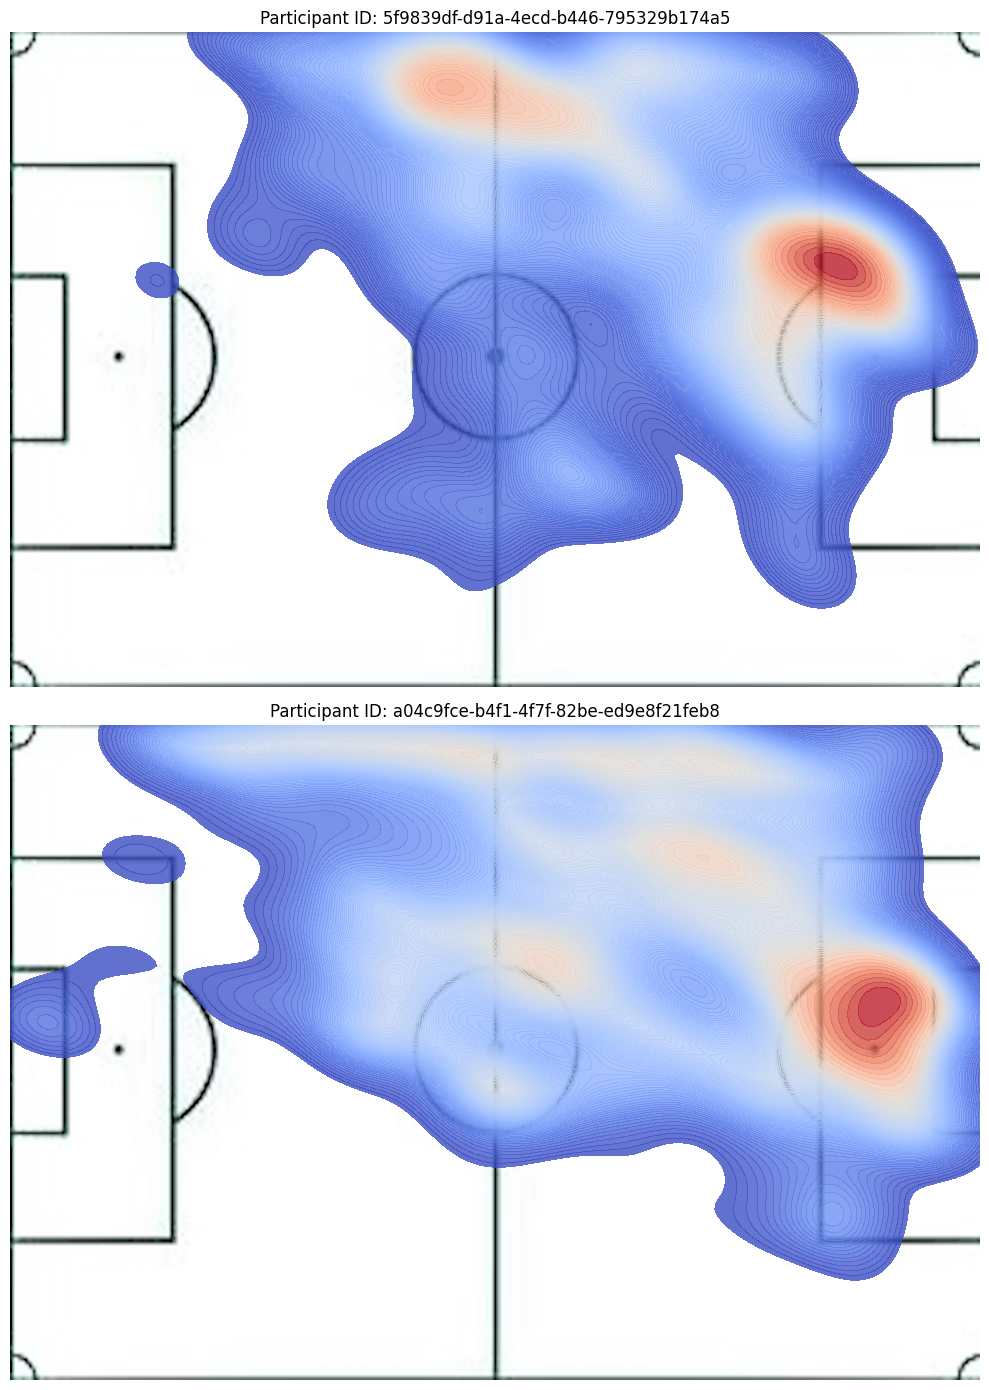

In [33]:
list_of_participants = ['5f9839df-d91a-4ecd-b446-795329b174a5', 'a04c9fce-b4f1-4f7f-82be-ed9e8f21feb8']

num_participants = len(list_of_participants)
fig, axes = plt.subplots(nrows=num_participants, ncols=1, figsize=(10, 7 * num_participants))

if num_participants == 1:
    axes = [axes]

for i, participant_id in enumerate(list_of_participants):
    participant_data = cleaned_data[(cleaned_data['Time (s)'] < 1730) & (cleaned_data['participation_id'] == participant_id)]

    axes[i].imshow(pitch_image, extent=extent, aspect='auto')

    sns.kdeplot(
        x=participant_data['Pitch_x'],
        y=participant_data['Pitch_y'],
        cmap="coolwarm",
        fill=True,
        alpha=0.8,
        levels=100,
        ax=axes[i]
    )
    axes[i].set_title(f"Participant ID: {participant_id}")

    axes[i].set_xlim(extent[0], extent[1])
    axes[i].set_ylim(extent[2], extent[3])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Okay so while they do occupy similar average positions they are not quite identical. These could be a left winger and left midfielder for example, or a right back and right midfielder perhaps.